In [52]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from torch import nn
import pandas as pd
import torch.utils.data as Data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

data = pd.read_csv(r'D:\AE_VScode\Battery_RUL.csv')
scaler = MinMaxScaler()#归一化方法：MinMax
# data = scaler.fit_transform(data)#归一化
data = data.to_numpy()
data = data[:,1:]
data = scaler.fit_transform(data)
data_x = data[:,0:7]
data_y = data[:,7:8]
# print(data[0])
# print(data_x[0])
# print(data_y[0])
#反归一化
#！！！！original_data = scaler.inverse_transform(data)！！！！
data_x = data_x.astype(np.float32)
data_y = data_y.astype(np.float32)
data_x = torch.from_numpy(data_x)
data_y = torch.from_numpy(data_y)#将 numpy 数组转换为 PyTorch 张量
print(type(data_x))
# data_x = data_x.cuda()
# data_y = data_y.cuda()
torch_dataset = Data.TensorDataset(data_x,data_y)#dataset封装
len(torch_dataset)
train_dataset,test_dataset = torch.utils.data.random_split(torch_dataset, [11000, 4064])#随机划分训练集，验证集，测试集

def getloader(torch_dataset):
    loader = Data.DataLoader(#Dataloader，这里调整batch_size
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=64,  # 每块的大小
        shuffle=True,  # 要不要打乱数据
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    return loader

train_loader = getloader(train_dataset)

test_loader = getloader(test_dataset)
print(type(train_loader))


<class 'torch.Tensor'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
class TAE(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(TAE, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
            
        )
        
    def forward(self, x):
        h = self.encoder(x)
        x_hat = self.decoder(h)
        y_hat = self.predictor(h)
        return x_hat, y_hat,h


class stae(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.tae1 = TAE(input_dim=7, output_dim=1, hidden_dim=6)       
        
        self.tae2 = TAE(input_dim=6, output_dim=1, hidden_dim=5)        
        
        self.tae3 = TAE(input_dim=5, output_dim=1, hidden_dim=4)
        
    def forward(self, x):
        x_hat, y_hat,h = self.tae1(x)
        x_hat2,y_hat2,h2 = self.tae2(h)
        x_hat3,y_hat3,h3 = self.tae3(h2)
        return y_hat3



In [77]:
def stae_loss(x_hat,x,y_hat, y, lambd_=1.0):
               
        re_loss = F.mse_loss(x_hat, x, reduction='mean')
             
        pre_loss = F.mse_loss(y_hat, y, reduction='mean')
        tae_loss = re_loss + lambd_ * lambd_ * pre_loss
        
        return tae_loss

lambda_ = 1
learning_rate = 0.001
pre_num_epochs = 5
num_epochs = 100

model = stae()
model.train()
#预训练

for epoch in range(pre_num_epochs):
    optimizer = optim.Adam(model.tae1.parameters(), lr=learning_rate)
    
    for x, y in train_loader:
        optimizer.zero_grad()
        x_hat, y_hat,h = model.tae1(x)
        loss = stae_loss(x_hat,x,y_hat,y,lambda_)
        
        loss.backward()
        optimizer.step()
        
    print("PreEpoch [{}/{}], tae1_Loss: {:.4f}".format(epoch+1, pre_num_epochs, loss.item()))

    
    for param in model.tae1.parameters():
        param.requires_grad = False

    optimizer = optim.Adam(model.tae2.parameters(), lr=learning_rate)

    for x, y in train_loader:
        optimizer.zero_grad()
        x_hat, y_hat,h = model.tae1(x)
        x_hat2,y_hat2,h2= model.tae2(h)
        loss = stae_loss(x_hat2,h,y_hat2,y,lambda_)
        loss.backward()
        optimizer.step()
        
    print("PreEpoch [{}/{}], tae2_Loss: {:.4f}".format(epoch+1, pre_num_epochs, loss.item()))

    for param in model.tae2.parameters():
        param.requires_grad = False

    optimizer = optim.Adam(model.tae3.parameters(), lr=learning_rate)
    
    for x, y in train_loader:
        optimizer.zero_grad()
        x_hat, y_hat,h = model.tae1(x)
        x_hat2,y_hat2,h2 = model.tae2(h)
        x_hat3,y_hat3,h3 = model.tae3(h2)
    
        loss = stae_loss(x_hat3,h2,y_hat3,y,lambda_)

        loss.backward()
        optimizer.step()
        
    print("preEpoch [{}/{}], tae3_Loss: {:.4f}".format(epoch+1, pre_num_epochs, loss.item()))
    
    for param in model.tae1.parameters():
        param.requires_grad = True
    for param in model.tae2.parameters():
        param.requires_grad = True

#微调
loss_s = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            predict = model(x)
            
            loss = criterion(y,predict)
            
            loss.backward()
            optimizer.step()
        loss_s.append(loss.item())    
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))

plt.plot(range(len(loss_s)), loss_s)
plt.title(f'stae_finally_e{num_epochs}_p{pre_num_epochs}Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.savefig(f"sae_finally_e{num_epochs}_p{pre_num_epochs}Train Loss")
plt.show()
torch.save(model.state_dict(), f"stae_finally_e{num_epochs}_p{pre_num_epochs}.pth")


PreEpoch [1/5], tae1_Loss: 0.1547
PreEpoch [1/5], tae2_Loss: 0.4071
preEpoch [1/5], tae3_Loss: 0.4509
PreEpoch [2/5], tae1_Loss: 0.1101
PreEpoch [2/5], tae2_Loss: 0.1263
preEpoch [2/5], tae3_Loss: 0.3813
PreEpoch [3/5], tae1_Loss: 0.0612
PreEpoch [3/5], tae2_Loss: 0.1435
preEpoch [3/5], tae3_Loss: 0.4625
PreEpoch [4/5], tae1_Loss: 0.0395
PreEpoch [4/5], tae2_Loss: 0.1769
preEpoch [4/5], tae3_Loss: 0.7614
PreEpoch [5/5], tae1_Loss: 0.0305
PreEpoch [5/5], tae2_Loss: 0.1946
preEpoch [5/5], tae3_Loss: 1.1431
Epoch [1/100], Loss: 0.4064
Epoch [2/100], Loss: 0.3582
Epoch [3/100], Loss: 0.3688
Epoch [4/100], Loss: 0.2662
Epoch [5/100], Loss: 0.3098
Epoch [6/100], Loss: 0.3803
Epoch [7/100], Loss: 0.3058
Epoch [8/100], Loss: 0.3249
Epoch [9/100], Loss: 0.2659
Epoch [10/100], Loss: 0.2792
Epoch [11/100], Loss: 0.3812
Epoch [12/100], Loss: 0.3077
Epoch [13/100], Loss: 0.3004
Epoch [14/100], Loss: 0.3147
Epoch [15/100], Loss: 0.3171
Epoch [16/100], Loss: 0.3144
Epoch [17/100], Loss: 0.3142
Epoch 

KeyboardInterrupt: 

AverageRMSE: 0.08303176570916548
MaxRMSE: 0.15805120766162872
MinRMSE: 0.05565357208251953
Average R2: 0.8947572541215111
Max: 0.9628024196662173
Min: 0.7008045976467869


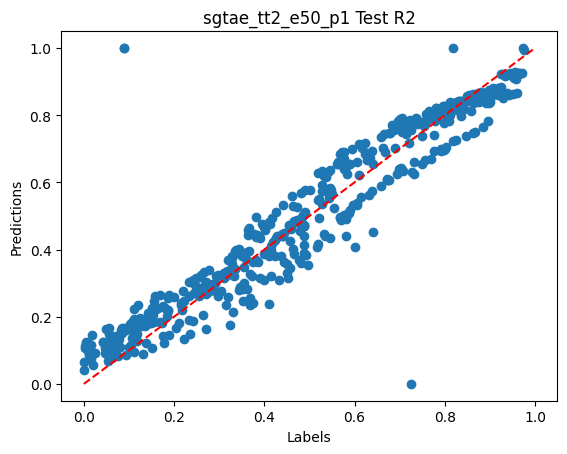

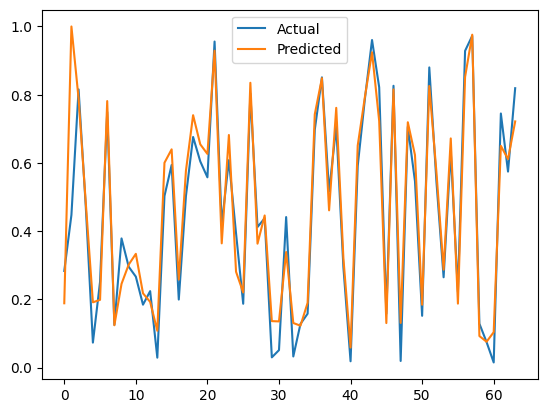

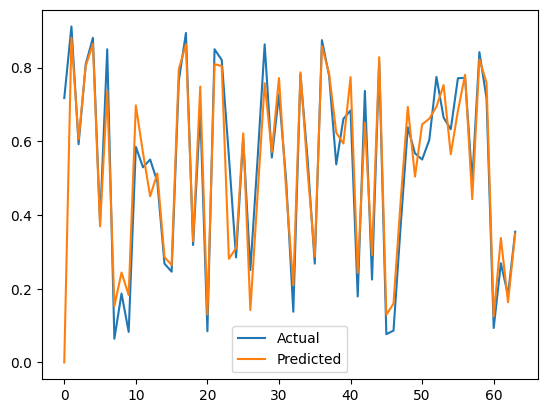

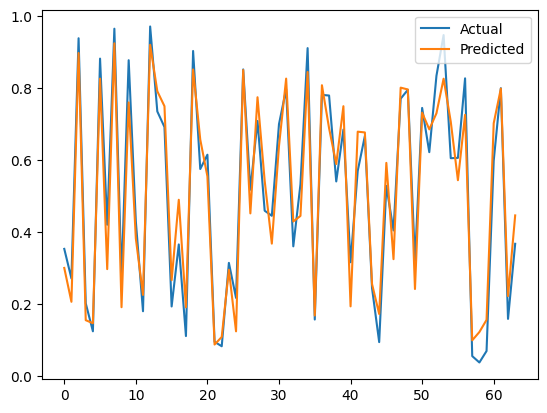

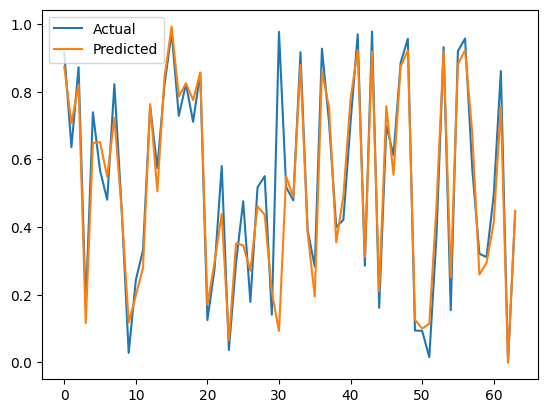

In [61]:
from sklearn.metrics import r2_score

def test_model(model, test_loader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss = torch.sqrt(loss)
            losses.append(loss.item())
    print('AverageRMSE:',sum(losses)/len(losses))
    AverageLoss = sum(losses)/len(losses)
    print('MaxRMSE:',max(list(losses)))
    MaxLoss = max(list(losses))
    print('MinRMSE:',min(list(losses)))
    MinLoss = min(list(losses))
    # plt.plot(range(len(losses)), losses)
    # plt.title(f'sgtae_tt2_e{num_epochs}_p{pre_num_epochs}Test Loss')
    # plt.xlabel('Batch')
    # plt.ylabel('Loss')
    # plt.show()
    return AverageLoss,MaxLoss,MinLoss

def test_R22(model, test_loader):
    model.eval()
    losses = []
    predictions_list = []
    labels_list = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            predictions = model(inputs)
            loss = r2_score(predictions, labels)
            losses.append(loss.item())
            predictions_list.append(predictions.numpy())
            labels_list.append(labels.numpy())
    print('Average R2:', sum(losses)/len(losses))
    AverageR2 = sum(losses)/len(losses)
    print('Max:', max(list(losses)))
    MaxR2 = max(list(losses))
    print('Min:', min(list(losses)))
    MinR2 = min(list(losses))
    
    predictions_list = np.concatenate(predictions_list, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    plt.scatter(labels_list[:500], predictions_list[:500])
    plt.plot([min(labels_list), max(labels_list)], [min(labels_list), max(labels_list)], color='red', linestyle='--')  # 添加四十五度线
    plt.title(f'sgtae_tt2_e{num_epochs}_p{pre_num_epochs} Test R2')
    plt.xlabel('Labels')
    plt.ylabel('Predictions')
    plt.show()
    
    return AverageR2, MaxR2, MinR2

def test1(model, test_loader):
        model.eval()
        i = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                predicted = model(inputs)
                plt.plot(np.array(labels), label='Actual')
                plt.plot(np.array(predicted), label='Predicted')
                plt.legend()
                plt.show()
                i+=1
                if i == 4:
                    break    
criterion1 = nn.MSELoss()
    
model_test = stae()
model_test.load_state_dict(torch.load(f"stae_finally_e{num_epochs}_p{pre_num_epochs}.pth"))
AverageLoss,MaxLoss,MinLoss = test_model(model_test,test_loader,criterion1)
AverageR2,MaxR2,MinR2 = test_R22(model_test,test_loader)
test1(model_test,test_loader)